# Clusters and Tracking Data
The purpose of this notebook is to generate data with corresponding clusters and tracks for both $\pi^0$ and $\pi^\pm$ data sets

These data sets can be quickly visualized and then saved into NP format or pickled

# Strategy:
### Use Single Track Events for Now
#### Event Filtering
1) Load branches from $\pi^\pm$ and $\pi^0$ data
2) Search through events in loop and find selection criteria. Save indices of event, track, and cluster
3) Use these indices to create np array of all the necessary data

## To Do:
1) ~~For now we use loops to select events but we want to vectorize this (maybe? maybe abandon this..)~~
2) ~~Create larger loop structure to take events with multiple tracks and match clusters to these~~
   - ~~This is done in LargerData_STMC.py and LargerData_STSC.py~~
3) ~~vectorize geoID cell search using np.tile() and np.argwhere()~~

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import uproot as ur
import awkward as ak
import time as t
import copy
import scipy.constants as spc
print("Awkward version: "+str(ak.__version__))
print("Uproot version: "+str(ur.__version__))

Awkward version: 1.4.0
Uproot version: 4.0.11


#### Data and Branches

In [2]:
track_branches = ['trackEta_EMB1', 'trackPhi_EMB1', 'trackEta_EMB2', 'trackPhi_EMB2', 'trackEta_EMB3', 'trackPhi_EMB3',
                  'trackEta_TileBar0', 'trackPhi_TileBar0', 'trackEta_TileBar1', 'trackPhi_TileBar1',
                  'trackEta_TileBar2', 'trackPhi_TileBar2']

event_branches = ["cluster_nCells", "cluster_cell_ID", "cluster_cell_E", 'cluster_nCells', "nCluster", "eventNumber",
                  "nTrack", "nTruthPart", "truthPartPdgId", "cluster_Eta", "cluster_Phi", 'trackPt', 'trackP',
                  'trackMass', 'trackEta', 'trackPhi', 'truthPartE', 'cluster_ENG_CALIB_TOT', "cluster_E", 'truthPartPt']

geo_branches = ["cell_geo_ID", "cell_geo_eta", "cell_geo_phi", "cell_geo_rPerp", "cell_geo_sampling"]

##### Make a calorimetry layer dictionary
Useful if we have a "switch" for sampling layer

In [5]:
sampling_layer_track_list = [1,1,2,2,3,3,12,12,13,13,14,14]
track_layer_dict = dict(zip(track_branches, sampling_layer_track_list))

for _key in track_branches:
    print(_key+': '+str(track_layer_dict[_key]))

trackEta_EMB1: 1
trackPhi_EMB1: 1
trackEta_EMB2: 2
trackPhi_EMB2: 2
trackEta_EMB3: 3
trackPhi_EMB3: 3
trackEta_TileBar0: 12
trackPhi_TileBar0: 12
trackEta_TileBar1: 13
trackPhi_TileBar1: 13
trackEta_TileBar2: 14
trackPhi_TileBar2: 14


## All Functions

In [26]:
def DeltaR(coords, ref):
    ''' Straight forward function, expects Nx2 inputs for coords, 1x2 input for ref '''
    ref = np.tile(ref, (len(coords[:,0]), 1))
    DeltaCoords = np.subtract(coords, ref)
    return np.sqrt(DeltaCoords[:,0]**2 + DeltaCoords[:,1]**2) 

def track_av(_arr):
    ''' Expects a (6,2) np array for the barrel layers in order of eta, phi '''
    _av_Eta = np.sum(_arr[:,0])/6
    _av_Phi = np.sum(_arr[:,1])/6
    return np.array([_av_Eta, _av_Phi])

def find_max_dim(_events, _event_dict):
    ''' This function is designed to return the sizes of a numpy array such that we are efficient
    with zero padding. Please feel free to write this faster, it can be done. Notes: we add six
    to the maximum cluster number such that we have room for track info.
    Inputs:
        _events: filtered list of events to choose from in an Nx3 format for event, track, cluster index 
        _event_tree: the event tree dictionary
    Returns:
        3-tuple consisting of (number of events, maximum cluster_size, 5), 5 because of how we have structured
        the X data format in energyFlow to be Eta, Phi, Energy, sampling layer, track flag,
        _cluster_ENG_CALIB_TOT, turthPartE '''
    _nEvents = len(_events)
    _max_clust = 0
    for i in range(_nEvents):
        _evt = _events[i,0]
        _clust_idx = _events[i,2]
        _num_in_clust = _event_dict['cluster_nCells'][_evt][_clust_idx]
        if _num_in_clust > _max_clust:
            _max_clust = _num_in_clust

    return (_nEvents, _max_clust+6, 6)

def find_max_dim_tuple(events, event_dict):
    nEvents = len(events)
    max_clust = 0
    
    for i in range(nEvents):
        event = events[i,0]
        track_nums = events[i,1]
        clust_nums = events[i,2]
        
        clust_num_total = 0
        # set this to six for now to handle single track events, change later
        track_num_total = 6
        
        # Check if there are clusters, None type object may be associated with it
        if clust_nums is not None:
            # Search through cluster indices
            for clst_idx in clust_nums:
                nInClust = len(event_dict['cluster_cell_ID'][event][clst_idx])
                # add the number in each cluster to the total
                clust_num_total += nInClust
                
#         if track_nums is not None:
#             for trck_idx in track_nums:
#                 # each track takes up six coordinates
#                 track_num_total += 6

        total_size = clust_num_total + track_num_total
        if total_size > max_clust:
            max_clust = total_size
    
    # 6 for energy, eta, phi, rperp, track flag, sample layer
    return (nEvents, max_clust, 6)
            
            

def track_coords(_idx, _event_dict, _track_dict, _track_branches):
    ''' Returns a list of numpy arrays which contain the track information in the order of
    EMB1->TileBar2. '''    
    _num_tracks = _event_dict['nTrack'][_idx]
    _track_arr = np.empty((_num_tracks,6,2))
    for i in range(_num_tracks):    
        _coords = np.empty((12,))
        j = 0
        for _key in _track_branches:
            _coords[j] = _track_dict[_key][_idx][i]
            j += 1
    _track_arr[i] = _coords.reshape(6,2)
    return _track_arr

def dict_from_event_tree(_event_tree, _branches):
    ''' The purpose for this separate function is to load np arrays where possible. '''
    _special_keys = ["nCluster", "eventNumber", "nTrack", "nTruthPart"]
    _dict = dict()
    for _key in _branches:
        if _key in _special_keys:
            _branch = _event_tree.arrays(filter_name=_key)[_key].to_numpy()
        else:
            _branch = _event_tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def dict_from_tree_branches(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. '''
    _dict = dict()
    for _key in _branches:
        _branch = _tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def dict_from_tree_branches_np(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. This always returns np arrays in the dict. '''
    _dict = dict()
    for _key in _branches:
        _branch = np.ndarray.flatten(_tree.arrays(filter_name=_key)[_key].to_numpy())
        _dict[_key] = _branch
    return _dict

def find_central_clusters(_event_dict):
    ''' Inputs:
        dictionary with events to pull cluster centers from
    Returns:
        an array of event indices with clusters with eta < .7 '''
    # list of event indices with one or more clusters in EMB1-3 or TileBar0-2
    _central_events = []
    _ak_cluster_cell_ID = _event_dict['cluster_cell_ID']
    
    for _evt_idx in range(len(_ak_cluster_cell_ID)):
        _cluster_Eta = event_dict['cluster_Eta'][_evt_idx].to_numpy()
        _cluster_Eta_mask = np.abs(_cluster_Eta) < .7
        
        if np.any(_cluster_Eta_mask):
            _central_events.append(_evt_idx)

    return np.array(_central_events)

def find_index_1D(values, dictionary):
    ''' Use a for loop and a dictionary. values are the IDs to search for. dict must be in format 
    (cell IDs: index) '''
    idx_vec = np.zeros(len(values), dtype=np.int32)
    for i in range(len(values)):
        idx_vec[i] = dictionary[values[i]]
    return idx_vec

# Load Data

In [7]:
# events = '/fast_scratch/atlas_images/v01-45/pipm/'
# my_event = ur.open(events+'user.angerami.24559744.OutputStream._000502.root')
# my_event.keys()

In [8]:
events = '/fast_scratch/atlas_images/v01-45/'
my_event = ur.open(events+'pipm_medium.root')
my_event.keys()

['EventTree;1', 'CellGeo;1']

### Event Tree

In [9]:
event_tree = my_event["EventTree"]
event_tree.show(name_width=42,
                interpretation_width=60)

name                                       | typename                 | interpretation                                              
-------------------------------------------+--------------------------+-------------------------------------------------------------
runNumber                                  | int32_t                  | AsDtype('>i4')
eventNumber                                | int64_t                  | AsDtype('>i8')
lumiBlock                                  | int32_t                  | AsDtype('>i4')
coreFlags                                  | uint32_t                 | AsDtype('>u4')
mcEventNumber                              | int32_t                  | AsDtype('>i4')
mcChannelNumber                            | int32_t                  | AsDtype('>i4')
mcEventWeight                              | float                    | AsDtype('>f4')
nTruthPart                                 | int32_t                  | AsDtype('>i4')
G4PreCalo_n_EM                        

In [10]:
event_dict = dict_from_event_tree(event_tree, event_branches)
print('Number of events: '+str(len(event_dict['eventNumber'])))

Number of events: 360000


#### Load Tracking Information

In [11]:
track_dict = dict_from_tree_branches(event_tree, track_branches)

### Geometry Tree

In [12]:
geo_file = ur.open('/fast_scratch/atlas_images/v01-45/cell_geo.root')
CellGeo_tree = geo_file["CellGeo"]
# CellGeo_tree = my_event['CellGeo']
CellGeo_tree.show(interpretation_width=60)

name                 | typename                 | interpretation                                              
---------------------+--------------------------+-------------------------------------------------------------
cell_geo_ID          | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), header_bytes=10)
cell_geo_sampling    | std::vector<uint16_t>    | AsJagged(AsDtype('>u2'), header_bytes=10)
cell_geo_eta         | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_phi         | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_rPerp       | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_deta        | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_dphi        | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_volume      | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_sigma       | std::vector<float> 

In [13]:
geo_dict = dict_from_tree_branches_np(CellGeo_tree, geo_branches)

## Filter events

### Criteria
 - [x] Single track events
 - [x] Track Pt > 500 MeV
 - [x] Cluster within < .2 DeltaR
 - [ ] Cluster Energy > 5%
 - [x] No other tracks with energy >10% of matched cluster

#### First select barrel events
Notes: Only use central cluster technique. Abandon searching sampling layers as searching for clusters is orders of magnitude faster. (3.56 hours versus .12 minutes for small root file)
### TO DO:
 - Make this a python script and save the output! Too slow otherwise and the connection tears
 - ~~Fix this to make it faster!!! Right now it's god awful~~
   - ~~Still slow as heck. Just ignore this part of the code and skip right to the track selection cuts~~
 - [x] Index Search using a dictionary, faster than vectorized numpy search

### Events with central clusters

In [15]:
t0 = t.time()
central_clusters = find_central_clusters(event_dict)
t1 = t.time()

print('Time in hours: '+str(round(((t1-t0)/3600), 2)))
print('Time in minutes: '+str(round( ((t1-t0)/60), 3)))
print('Time in seconds: '+str(round((t1-t0), 2) ))

Time in hours: 0.0
Time in minutes: 0.299
Time in seconds: 17.92


### Track Filter
#### Single Track

In [16]:
# create ordered list of events to use for index slicing
nEvents = len(event_dict['eventNumber'])
all_events = np.arange(0,nEvents,1,dtype=np.int32)

# SINGLE TRACK CUT
single_track_mask = event_dict['nTrack'] == np.full(nEvents, 1)
filtered_event = all_events[single_track_mask]
print('Single Track Indices, shape '+str(np.shape(filtered_event)))
print(filtered_event[0:20])

Single Track Indices, shape (218392,)
[ 1  2  3  4  7  8 12 15 17 18 19 20 21 23 24 25 27 28 29 30]


#### Central Tracks

In [17]:
trackEta_EMB1 = ak.flatten(track_dict['trackEta_EMB1'][filtered_event]).to_numpy()
central_track_mask = np.abs(trackEta_EMB1) < .7
filtered_event = filtered_event[central_track_mask]
# Save this for processing track only files later
central_single_tracks = filtered_event
print('Central track indices, shape '+str(np.shape(filtered_event)))
print(filtered_event[0:20])

Central track indices, shape (69414,)
[ 3  8 18 20 21 23 27 28 30 34 35 36 41 43 44 50 53 59 63 70]


#### Tracks with Clusters

In [18]:
nCluster = event_dict['nCluster'][filtered_event]
filtered_event_mask = nCluster != 0
filtered_event = filtered_event[filtered_event_mask]
print('Tracks with clusters, shape '+str(np.shape(filtered_event)))
print(filtered_event[0:20])

Tracks with clusters, shape (60176,)
[ 3  8 18 20 21 23 27 28 34 35 36 41 43 44 50 53 59 63 70 74]


#### Momentum Cuts, 500 MeV
This is basically useless but here for completeness

In [19]:
trackP = ak.flatten(event_dict['trackP'][filtered_event]).to_numpy()
filtered_event_mask = trackP > .5
filtered_event = filtered_event[filtered_event_mask]
print('Tracks with momentum cuts, shape '+str(np.shape(filtered_event)))
print(filtered_event[0:40])

Tracks with momentum cuts, shape (60176,)
[  3   8  18  20  21  23  27  28  34  35  36  41  43  44  50  53  59  63
  70  74  93  99 102 107 112 116 117 122 123 124 135 137 148 149 156 158
 161 162 170 174]


## Cluster Track Matching
#### Apply $\Delta R$ cut <.2
 - All clusters within $\Delta R < .2$
 
#### To Do:
 - Use multiple clusters -- combine?
 
#### Notes:
 - Currently changing notebook to accept multiple clusters as a tuple
 - This is used as a proxy for multiple tracks

In [23]:
# Note we have to keep this a list becuase it may be shorter than filtered events if critera are not met
event_indices = []
t0 = t.time()

for _evt in filtered_event:

    # pull cluster number, don't need zero as it's loaded as a np array
    _nClust = event_dict["nCluster"][_evt]
    cluster_idx = np.arange(_nClust)
    
    # Notes: this will need to handle more complex scenarios in the future for tracks with
    # no clusters
    
    ## DELTA R ##
    # pull coordinates of tracks and clusters from event
    # we can get away with the zeroth index because we are working with single track events
    _trackCoords = np.array([event_dict["trackEta"][_evt][0],
                             event_dict["trackPhi"][_evt][0]])
    _clusterCoords = np.stack((event_dict["cluster_Eta"][_evt].to_numpy(),
                               event_dict["cluster_Phi"][_evt].to_numpy()), axis=1)

    _DeltaR = DeltaR(_clusterCoords, _trackCoords)
    _DeltaR_mask = _DeltaR < .2
    matched_clusters = cluster_idx[_DeltaR_mask]
    
    ## CREATE LIST ##
    # Note: currently do not have track only events. Do this in the future    
    if np.count_nonzero(_DeltaR_mask) > 0:
        event_indices.append((_evt, 0, matched_clusters))

t1 = t.time()
print('Time in hours: '+str(round(((t1-t0)/3600), 2)))
print('Time in minutes: '+str(round( ((t1-t0)/60), 3)))
print('Time in seconds: '+str(round((t1-t0), 2) ))
event_indices = np.array(event_indices, dtype=np.object_)
print("Total number of events: "+str(len(event_indices)))
print(event_indices[0:10])

Time in hours: 0.0
Time in minutes: 0.2
Time in seconds: 12.01
Total number of events: 55163
[[3 0 array([0, 1, 2, 3])]
 [18 0 array([0])]
 [20 0 array([0])]
 [21 0 array([0])]
 [23 0 array([0])]
 [27 0 array([0, 1])]
 [34 0 array([0])]
 [35 0 array([0, 1])]
 [36 0 array([0])]
 [41 0 array([0, 1])]]


## Input Data

#### Find np.array Dimensions

In [27]:
max_dims = find_max_dim_tuple(event_indices, event_dict)
print(max_dims)

(55163, 888, 6)


In [37]:
X = np.zeros(max_dims)
Y = np.zeros(max_dims[0])
# these are only approximate?
layer_rPerp = np.array([1540., 1733., 1930., 2450., 3010., 3630.])
track_sample_layer = np.array([1,2,3,12,13,14])
        
# cell geometry data
cell_geo_ID = geo_dict['cell_geo_ID']
cell_ID_dict = dict(zip(cell_geo_ID, np.arange(len(cell_geo_ID))))

t0 = t.time()
for i in range(max_dims[0]):
    # pull all relevant indices
    evt = event_indices[i,0]
    track_idx = event_indices[i,1]
    # recall this now returns an array
    cluster_nums = event_indices[i,2]
    
    ##############
    ## CLUSTERS ##
    ##############
    if cluster_nums is not None:
        
        # find averaged center of clusters
        cluster_Eta = event_dict['cluster_Eta'][evt].to_numpy()
        cluster_Phi = event_dict['cluster_Phi'][evt].to_numpy()
        av_Eta = np.mean(cluster_Eta)
        av_Phi = np.mean(cluster_Phi)
        
        nClust_current_total = 0
        for c in cluster_nums:            
            # cluster data
            cluster_cell_ID = event_dict['cluster_cell_ID'][evt][c].to_numpy()
            nInClust = len(cluster_cell_ID)
            cluster_cell_E = event_dict['cluster_cell_E'][evt][c].to_numpy()            
            cell_indices = find_index_1D(cluster_cell_ID, cell_ID_dict)
            
            cluster_cell_Eta = geo_dict['cell_geo_eta'][cell_indices]
            cluster_cell_Phi = geo_dict['cell_geo_phi'][cell_indices]
            cluster_cell_rPerp = geo_dict['cell_geo_rPerp'][cell_indices]
            cluster_cell_sampling = geo_dict['cell_geo_sampling'][cell_indices]

            # input all the data
            # note here we leave the fourth entry zeros (zero for flag!!!)
            low = nClust_current_total
            high = low + nInClust
            X[i,low:high,0] = cluster_cell_E
            # Normalize to average cluster centers
            X[i,low:high,1] = cluster_cell_Eta - av_Eta
            X[i,low:high,2] = cluster_cell_Phi - av_Phi
            X[i,low:high,3] = cluster_cell_rPerp
            X[i,low:high,5] = cluster_cell_sampling
            
            nClust_current_total += nInClust
   
    #####################
    ## TARGET ENERGIES ##
    #####################
    truthPartE = event_dict['truthPartE'][evt][0]
    Y[i] = truthPartE
    
    ############
    ## TRACKS ##
    ############
    
    trackP = event_dict['trackP'][_evt][track_idx]

    track_arr = np.zeros((6,6))
    track_arr[:,5] = track_sample_layer
    # track flag
    track_arr[:,4] = np.ones((6,))
    track_arr[:,3] = layer_rPerp
    
    # Fill in eta and phi values
    # this is complicated - simplify?
    p, q = 0, 1
    for j in range(12):
        # This gives the key for the track dict
        track_arr[p,q] = track_dict[track_branches[j]][evt][track_idx]
        if j%2 != 0:
            p += 1
            q = 1
        else:
            q = 2
    
    # search for NULL track flags
    track_eta_null_mask = np.abs(track_arr[:,1]) > 4.9
    track_phi_null_mask = np.abs(track_arr[:,2]) >= np.pi
    track_flag_null = np.logical_or(track_eta_null_mask, track_phi_null_mask)
    
    # where the flag is set to null, set values of energy and calo layer to zero
    if np.any(track_flag_null):
        # number for which to spread the energy out over
        p_nums = 6 - np.count_nonzero(track_flag_null)
        track_arr[track_flag_null,1:6] = 0
        # get where the track exists (not null)
        track_arr[np.invert(track_flag_null),0] = trackP/p_nums
    # otherwise fill in pt/6 for all
    else:
        track_arr[:,0] = trackP/6      

    X[i,high:high+6,0:6] = track_arr
#####################################################
t1 = t.time()

print('Finished constructing X, Y array! :-)')
print('Time in hours: '+str(round( (t1-t0)/3600, 2)))
print('Time in minutes: '+str(round( (t1-t0)/60, 2)))
print('Time in seconds: '+str(round( (t1-t0), 2)))

Finished constructing X, Y array! :-)
Time in hours: 0.02
Time in minutes: 0.92
Time in seconds: 54.98


In [36]:
np.savez('XY_tracks_multipleClusters_med', X, Y)

#### Using loop search for gell_geo_ID
Finished constructing X, Y array! :-)
Time in hours: 0.52
Time in minutes: 31.28
Time in seconds: 1876.53

## Save Cluster Only Regression Data

In [16]:
nCentralClusterEvts = len(central_clusters)
print('Number of events with central clusters: '+str(nCentralClusterEvts))

Number of events with central clusters: 82975


Further refine this with list of central clusters which are max energy, and find the max size of the list.

In [22]:
max_cluster_size = 0
single_cluster_only = []

t0 = t.time()
for i in range(nCentralClusterEvts):
    _evt = central_clusters[i]
    
    # pull cluster center
    _cluster_Eta = event_dict['cluster_Eta'][_evt].to_numpy()
    
    # check if clusters have eta < .7
    _clst_cntr_mask = np.abs(_cluster_Eta) < .7
    
    # check which cluster is the max energy, make mask
    _clstr_E = event_dict['cluster_E'][_evt].to_numpy()
    _clstr_E_mask = _clstr_E == np.max(_clstr_E)
    
    # both max energy and central
    _evt_mask = np.logical_and(_clst_cntr_mask, _clstr_E_mask)
    
    # if both are true pull the index
    if np.any(_evt_mask):
        _clstr_idx = np.argmax(_evt_mask)
        single_cluster_only.append((_evt, _clstr_idx))
        
    _current_clust_num = len(event_dict['cluster_cell_ID'][_evt][_clstr_idx])
    if _current_clust_num > max_cluster_size:
        max_cluster_size = _current_clust_num

t1 = t.time()
single_cluster_only = np.array(single_cluster_only)
print('Max cluster size: '+str(max_cluster_size))
print('Shape of single cluster index array: '+str(single_cluster_only.shape))
print('Time in hours: '+str(round( (t1-t0)/3600, 2)))
print('Time in minutes: '+str(round( (t1-t0)/60, 2)))
print('Time in seconds: '+str(round( (t1-t0), 2)))

Max cluster size: 929
Shape of single cluster index array: (68516, 2)
Time in hours: 0.0
Time in minutes: 0.2
Time in seconds: 12.15


#### Create Arrays

In [32]:
Y_sc = np.empty(single_cluster_only.shape[0])
X_sc = np.zeros((single_cluster_only.shape[0], max_cluster_size, 5))

t0 = t.time()
for i in range(len(single_cluster_only)):
    _evt = single_cluster_only[i,0]
    _clstr = single_cluster_only[i,1]
    
    _cluster_cell_ID = event_dict['cluster_cell_ID'][_evt][_clstr].to_numpy()
    _cell_geo_ID = geo_dict['cell_geo_ID']
    _cluster_Eta = event_dict['cluster_Eta'][_evt][_clstr]
    _cluster_Phi = event_dict['cluster_Phi'][_evt][_clstr]
    _nInClust = len(_cluster_cell_ID)
#     _geo_idx = find_index_1D(_cluster_cell_ID, geo_dict['cell_geo_ID'])
    
    _cell_idx = np.zeros(_nInClust, dtype=np.int32)
    for j in range(_nInClust):
        _cell_ID = _cluster_cell_ID[j]
        _cell_idx[j] = np.where(_cell_ID == _cell_geo_ID)[0][0]
    
    X_sc[i,0:_nInClust,0] = event_dict['cluster_cell_E'][_evt][_clstr].to_numpy()
    X_sc[i,0:_nInClust,1] = geo_dict['cell_geo_eta'][_cell_idx] - _cluster_Eta
    X_sc[i,0:_nInClust,2] = geo_dict['cell_geo_phi'][_cell_idx] - _cluster_Phi
    X_sc[i,0:_nInClust,3] = geo_dict['cell_geo_rPerp'][_cell_idx]
    X_sc[i,0:_nInClust,4] = geo_dict['cell_geo_sampling'][_cell_idx]
    
    # save target
    Y_sc[i] = event_dict['cluster_ENG_CALIB_TOT'][_evt][_clstr]
t1 = t.time()

print(X_sc.shape)
print(Y_sc.shape)
print('Time in hours: '+str(round( (t1-t0)/3600, 2)))
print('Time in minutes: '+str(round( (t1-t0)/60, 2)))
print('Time in seconds: '+str(round( (t1-t0), 2)))

(68516, 929, 5)
(68516,)
Time in hours: 0.19
Time in minutes: 11.2
Time in seconds: 671.89


In [34]:
# np.savez('/fast_scratch/atlas_images/v01-45/XY_clustersOnly_med', X_sc, Y_sc)

## Save Track Only Regression Data

In [78]:
nTrackOnlyEvts = len(central_single_tracks)
# Deep set information
X_tracksOnly_med = np.empty((nTrackOnlyEvts, 6, 5))
# Truth to work towards
Y_tracksOnly_med = np.empty((nTrackOnlyEvts,))

# additional information
layer_rPerp = np.array([1540., 1733., 1930., 2450., 3010., 3630.])
track_sample_layer = np.array([1,2,3,12,13,14])

t0 = t.time()
for i in range(len(central_single_tracks)):
    
    _evt = central_single_tracks[i]
    
    _track_arr = np.zeros((6,5))
    _track_arr[:,4] = track_sample_layer
    _track_arr[:,3] = layer_rPerp
    
    p, q = 0, 1
    for j in range(12):
        # This gives the key for the track dict
        _track_arr[p,q] = track_dict[track_branches[j]][_evt][0]
        if j%2 != 0:
            p += 1
            q = 1
        else:
            q = 2

    ## TRACK MOMENTUM ##
    _trackPt = event_dict['trackPt'][_evt][0]
    
    # search for NULL track flags
    _track_eta_null_mask = np.abs(_track_arr[:,1]) > 4.9
    _track_phi_null_mask = np.abs(_track_arr[:,2]) >= np.pi
    _track_flag_null = np.logical_or(_track_eta_null_mask, _track_phi_null_mask)
    
    # where the flag is set to null, set values of energy and calo layer to zero
    if np.any(_track_flag_null):
        # number for which to spread the energy out over
        pt_nums = 6 - np.count_nonzero(_track_flag_null)
        _track_arr[_track_flag_null,1] = 0
        _track_arr[_track_flag_null,2] = 0
        # get where the track exists (not null)
        _track_arr[np.invert(_track_flag_null),0] = _trackPt/pt_nums
    # otherwise fill in pt/6 for all
    else:
        _track_arr[:,0] = _trackPt/6

    X_tracksOnly_med[i,:,:] = _track_arr
    Y_tracksOnly_med[i] = event_dict['truthPartPt'][_evt][0]

t1 = t.time()
print('Finished constructing track only deep sets !! :-)')
print('Time in hours: '+str(round( (t1-t0)/3600, 2)))
print('Time in minutes: '+str(round( (t1-t0)/60, 2)))
print('Time in seconds: '+str(round( (t1-t0), 2)))

Finished constructing track only deep sets !! :-)
Time in hours: 0.01
Time in minutes: 0.35
Time in seconds: 20.94


In [80]:
print(X_tracksOnly_med[0,:,:])
# np.savez('/fast_scratch/atlas_images/v01-45/XY_tracksOnly_Pt_distributed_med', X_tracksOnly_med, Y_tracksOnly_med)

[[ 5.61663462e+01 -8.56832936e-02  1.34370983e+00  1.54000000e+03
   1.00000000e+00]
 [ 5.61663462e+01 -8.56831744e-02  1.34371960e+00  1.73300000e+03
   2.00000000e+00]
 [ 5.61663462e+01 -8.56830403e-02  1.34372663e+00  1.93000000e+03
   3.00000000e+00]
 [ 5.61663462e+01 -8.56827945e-02  1.34373271e+00  2.45000000e+03
   1.20000000e+01]
 [ 5.61663462e+01 -8.56854618e-02  1.34375322e+00  3.01000000e+03
   1.30000000e+01]
 [ 5.61663462e+01 -8.56948122e-02  1.34380674e+00  3.63000000e+03
   1.40000000e+01]]


## Post Event Histograms

##### Post cluster cuts

In [30]:
num_plat = len(platinum_events)
pe_trackP = np.empty(num_plat)
pe_cluster_E = np.empty(num_plat)
pe_cluster_ENG_CALIB_TOT = np.empty(num_plat)

for i in range(num_plat):
    _evt = platinum_events[i,0]
    _track_idx = platinum_events[i,1]
    _cluster_idx = platinum_events[i,2]
    pe_trackP[i] = event_dict['trackP'][_evt][_track_idx]
    pe_cluster_E[i] = event_dict['cluster_E'][_evt][_cluster_idx]
    pe_cluster_ENG_CALIB_TOT[i] = event_dict['cluster_ENG_CALIB_TOT'][_evt][_cluster_idx]

##### Pre cluster cuts

In [34]:
num_filt = len(event_indices)
ge_trackP = np.empty(num_filt)
ge_cluster_E = np.empty(num_filt)
ge_cluster_ENG_CALIB_TOT = np.empty(num_filt)

for i in range(num_filt):
    _evt = event_indices[i,0]
    _track_idx = event_indices[i,1]
    _cluster_idx = event_indices[i,2]
    ge_trackP[i] = event_dict['trackP'][_evt][_track_idx]
    ge_cluster_E[i] = event_dict['cluster_E'][_evt][_cluster_idx]
    ge_cluster_ENG_CALIB_TOT[i] = event_dict['cluster_ENG_CALIB_TOT'][_evt][_cluster_idx]

#### Plots

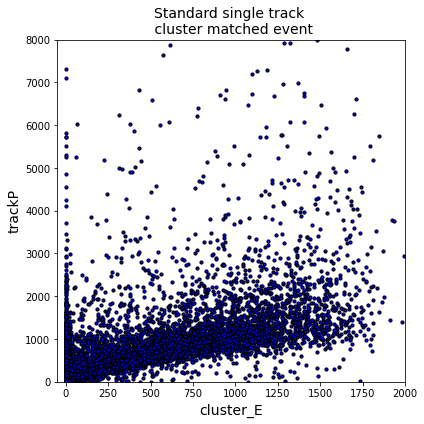

In [44]:
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.scatter(ge_cluster_E, ge_trackP, s=10,edgecolor='black', color='blue')
plt.title('Standard single track \n cluster matched event', fontsize=14)
plt.xlabel('cluster_E', fontsize=14)
plt.ylabel('trackP', fontsize=14)
plt.ylim(0,8e3)
plt.xlim(-50,2000)
# plt.tight_layout()
# plt.savefig('Plots/clusterE_trackP_golden_2021-06-03.png', format='png')
plt.show()

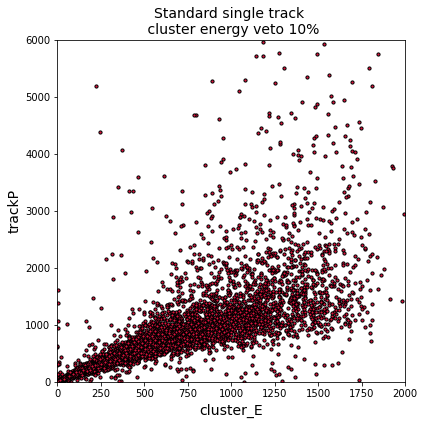

In [50]:
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.scatter(pe_cluster_E, pe_trackP, s=10,edgecolor='black', color='crimson')
plt.title('Standard single track \n cluster energy veto 10%', fontsize=14)
plt.xlabel('cluster_E', fontsize=14)
plt.ylabel('trackP', fontsize=14)
plt.ylim(0,6e3)
plt.xlim(0,2000)
# plt.tight_layout()
# plt.savefig('Plots/clusterE_trackP_platinum_2021-06-03.png', format='png')
plt.show()

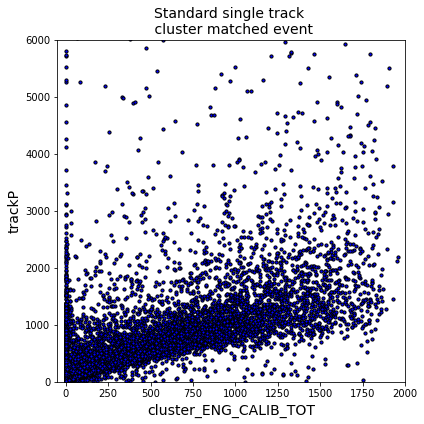

In [51]:
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.scatter(ge_cluster_ENG_CALIB_TOT, ge_trackP, s=10, edgecolor='black', color='blue')
plt.title('Standard single track \n cluster matched event', fontsize=14)
plt.xlabel('cluster_ENG_CALIB_TOT', fontsize=14)
plt.ylabel('trackP', fontsize=14)
plt.ylim(0,6e3)
plt.xlim(-50,2000)
# plt.tight_layout()
# plt.savefig('Plots/cluster_ENG_CALIB_TOT_trackP_gold_2021-06-03.png', format='png')
plt.show()

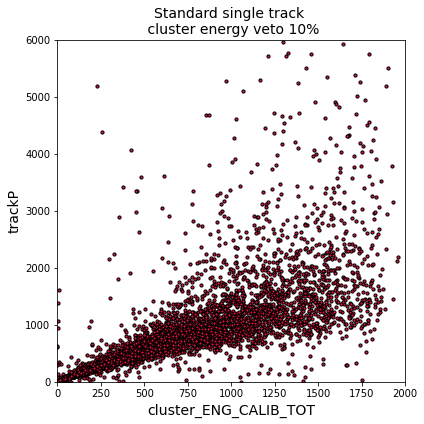

In [52]:
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.scatter(pe_cluster_ENG_CALIB_TOT, pe_trackP, s=10,edgecolor='black', color='crimson')
plt.title('Standard single track \n cluster energy veto 10%', fontsize=14)
plt.xlabel('cluster_ENG_CALIB_TOT', fontsize=14)
plt.ylabel('trackP', fontsize=14)
plt.ylim(0,6e3)
plt.xlim(0,2000)
# plt.tight_layout()
# plt.savefig('Plots/cluster_ENG_CALIB_TOT_trackP_platinum_2021-06-03.png', format='png')
plt.show()

#### Histograms

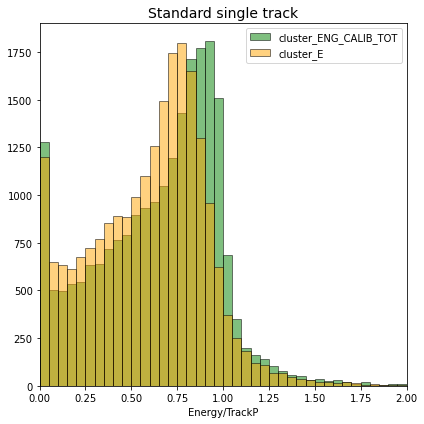

In [77]:
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist(ge_cluster_ENG_CALIB_TOT/ge_trackP, bins=40, range=(0,2), edgecolor='black', alpha=.5, color='green',
         label='cluster_ENG_CALIB_TOT')
plt.hist(ge_cluster_E/ge_trackP, bins=40, range=(0,2), edgecolor='black', alpha=.5, color='orange',
         label='cluster_E')
plt.title('Standard single track', fontsize=14)
plt.legend()
plt.xlim(0,2)
plt.xlabel('Energy/TrackP')
# plt.tight_layout()
# plt.savefig('Plots/E_P_hist_gold_2021-06-03.png', format='png')
plt.show()

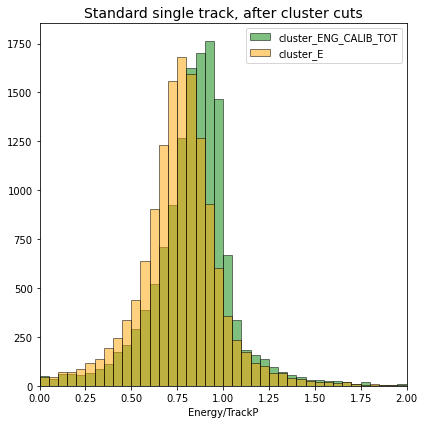

In [78]:
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.hist(pe_cluster_ENG_CALIB_TOT/pe_trackP, bins=40, range=(0,2), edgecolor='black', alpha=.5, color='green',
         label='cluster_ENG_CALIB_TOT')
plt.hist(pe_cluster_E/pe_trackP, bins=40, range=(0,2), edgecolor='black', alpha=.5, color='orange',
         label='cluster_E')
plt.title('Standard single track, after cluster cuts', fontsize=14)
plt.legend()
plt.xlim(0,2)
plt.xlabel('Energy/TrackP')
# plt.tight_layout()
# plt.savefig('Plots/E_P_hist_platinum_2021-06-03.png', format='png')
plt.show()

# Testing Things: Ignore Below

#### This can only mean that there are repeats in cell_geo_ID !?

In [48]:
cell_geo_ID = geo_dict['cell_geo_ID']
print('Length of cell_geo_ID: '+str(len(cell_geo_ID)))
_cell_geo_unique = np.unique(cell_geo_ID)
print('Number of unique elements: '+str(len(_cell_geo_unique)))

Length of cell_geo_ID: 187650
Number of unique elements: 187650


In [209]:
sorted_arr = np.arange(0,8,1)
unsorted_arr = np.array([3,4,2,2,1,5,0,0])
print(sorted_arr)
print(unsorted_arr)
indices = np.ndarray.flatten(np.argwhere(np.asarray(sorted_arr == unsorted_arr)))
print(indices)

my_mask = np.array([True, False, False, True])
my_array = np.ones(4)
my_array[my_mask] = 0
print(my_array)

[0 1 2 3 4 5 6 7]
[3 4 2 2 1 5 0 0]
[2 5]
[0. 1. 1. 0.]


### Vectorize cell ID search

In [28]:
## Build dictionary here

In [31]:
def find_index_1D_dict(_values, _dict):
    ''' Use a for loop and a dictionary '''
    _shape = (len(_values), len(_unsorted))
    # convert this to rows 
    _values_2D_T = np.atleast_2d(_values).transpose()
    _unsorted_2d = np.tile(_unsorted, _shape[0]).reshape(_shape)
    _idx_vec = np.argmax(np.asarray(_values_2d == _unsorted_2d), axis=1)
    return _idx_vec

def find_index_1D_pythonic(_values, _unsorted):
    ''' pythonic implementation of stacking array '''
    # convert this to rows 
    _values_2D_T = np.atleast_2d(_values).transpose()
    _unsorted_2d = [_unsorted]*len(_values)
    _idx_vec = np.nonzero(_values_2d_T == _unsorted_2d, axis=0)
    return _idx_vec

def find_index_1D_tile(_values, _unsorted):
    ''' tile and reshape the array '''
    # convert this to rows 
    _values_2D_T = np.atleast_2d(_values).transpose()
    print(_values_2D)
    _unsorted_2d = np.tile(_unsorted, (len(_values),1))
    print(_unsorted_2d)
    _idx_vec = np.nonzero(_values_2d_T == _unsorted_2d, axis=0)
    print(_idx_vec)
    return _idx_vec

def find_index_1D_vstack(_values, _unsorted):
    ''' use vstack a bunch '''
    _shape = (len(_values), len(_unsorted))
    # convert this to rows 
    _values_2D_T = np.atleast_2d(_values).transpose()
    _unsorted_2d = np.tile(_unsorted, _shape[0]).reshape(_shape)
    _idx_vec = np.argmax(np.asarray(_values_2d == _unsorted_2d), axis=1)
    return _idx_vec

Finding: [2 3 4]
In: [0 5 9 6 1 7 2 3 8 4]


In [33]:
my_find = find_index_1D(_tags, unsorted_array)
print('resulting indices')
print(my_find)

shape
(3, 10)
values_2d
[[2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4]]
unsorted_2d
[[0 5 9 6 1 7 2 3 8 4]
 [0 5 9 6 1 7 2 3 8 4]
 [0 5 9 6 1 7 2 3 8 4]]
index vector
[[0 6]
 [1 7]
 [2 9]]
resulting indices
[6 7 9]


In [113]:
# Create array of ID elements
_tags_2d = np.repeat(_tags, repeats=len(unsorted_array)).reshape((len(_tags), len(unsorted_array)))
print(_tags_2d)

# Create stacked list of what to compare to
unsorted_2d = np.tile(unsorted_array, reps=len(_tags)).reshape((len(_tags), len(unsorted_array)))
print(unsorted_2d)

# now use comparison
idx_vect = np.argwhere(np.asarray( _tags_2d == unsorted_2d ))[:,1]
print(idx_vect)

[[2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3]]
[[2 4 5 0 3 6 1 7]
 [2 4 5 0 3 6 1 7]]
[0 4]


In [85]:

unsorted_tiled = np.tile(unsorted_array, len(_tags))
print('Tags:')
print(tags_tiled)
print('Unsorted array')
print(unsorted_array)

ValueError: cannot reshape array of size 2 into shape (2,2)

##### Using np.where()

In [75]:
_tag_mask = np.where(unsorted_array == _tags)
print(_tag_mask)

(array([], dtype=int64),)


<ipython-input-75-379848478688>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  _tag_mask = np.where(unsorted_array == _tags)


##### Using argwhere

In [78]:
indices = np.ndarray.flatten(np.argwhere(np.asarray(unsorted_array == _tags)))
print(indices)

[]


<ipython-input-78-866f63f4dfa9>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  indices = np.ndarray.flatten(np.argwhere(np.asarray(unsorted_array == _tags)))


##### Check this speed against dictionaries

In [71]:
cellGeoDict = {}
_tag_idx = 0
for _cell_tag in geo_dict['cell_geo_ID'][0:10]:
    if _tag_idx <= 5:
        print(_cell_tag)
    cellGeoDict[_cell_tag] = _tag_idx
    _tag_idx += 1

# 740294660 this should be index three
print('For element 740294660 this produces index: '+str(cellGeoDict[740294660]))

740294656
740294658
740294660
740294662
740294664
740294666
For element 740294660 this produces index: 2
